# 06.1 - Pyspark Common Operations

In this notebook we'll take a look at some common pyspark operation:
* join
* union
* groupBy
* toPandas or "bringing data to local".

Imagine handling an excel file. But the excel file is the size of a small planet. If you conceptualize a spark dataframe as a large excel sheet that has to be handled with special code, you will be able to conceptualize the transformations you wish to perform. If you have an SQL background, you will probably already know some of these operations.

---
## Join

A Join is an operation in [relational databases](https://en.wikipedia.org/wiki/Relational_database) where you combine the registries between two tables. If you have an SQL background you should be familiar with this operation. With a join, you can match where two tables match under any combination of column values. The two tables are usually defined as __left__ and __right__, as these operations are normally non-commutative. The __left__ table is the table you include in the line of code first.

<div class="alert alert-warning">
    <b> The definitions presented here are the very basic definition of the join operations. There are extensions to these models that expand their functionalities.<b>
</div>

Let's take a look at several common join types in pyspark.

### Left join

The left join is probably the most common join. It is called this way because the right table is added to the left table when the match is possible. In a sense, the left table is still intact inside the final resulting table. When you add columns to a table in a way all the original content of the original table is still present, we say the left table was __enriched__.

Records in an existing column that have no match are filled with a __null__.

<img src="../Figures/left_join.gif" width=400>

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('adpro').getOrCreate()## Remember: When you create a session in a cluster, it is possible for a sysadmin to follow your resource usage.

In [2]:
simpleEntries = [('Duck', 6, True, 'pond'),
                 ('Goose', 5, True, 'farm'),
                 ('Dog', 4, False, 'farm'),
                 ('Wolf', 5, False, 'woods')]

exampleTableA = spark.createDataFrame(simpleEntries, ['name', 'speed', 'flies', 'place'])

In [3]:
exampleTableA.show() ## This is way too slow!! Why?

+-----+-----+-----+-----+
| name|speed|flies|place|
+-----+-----+-----+-----+
| Duck|    6| true| pond|
|Goose|    5| true| farm|
|  Dog|    4|false| farm|
| Wolf|    5|false|woods|
+-----+-----+-----+-----+



In [4]:
simpleEntries = [('farm', 'pet'),
                 ('woods', 'wild')]

exampleTableB = spark.createDataFrame(simpleEntries, ['place', 'category'])

In [5]:
exampleTableB.show()

+-----+--------+
|place|category|
+-----+--------+
| farm|     pet|
|woods|    wild|
+-----+--------+



In [6]:
exampleTableA.join(exampleTableB, on=['place'], how='left') ## This is just a transformation. We haven't actually instructed any actions yet.

DataFrame[place: string, name: string, speed: bigint, flies: boolean, category: string]

In [7]:
resultDF = exampleTableA.join(exampleTableB, on=['place'], how='left') ## This is just a transformation. We haven't actually instructed any actions yet.

In [8]:
resultDF

DataFrame[place: string, name: string, speed: bigint, flies: boolean, category: string]

In [9]:
resultDF.show() ## At this point, the interpreter will read exampleTableA, exampleTableB, and join them

+-----+-----+-----+-----+--------+
|place| name|speed|flies|category|
+-----+-----+-----+-----+--------+
| farm|Goose|    5| true|     pet|
| farm|  Dog|    4|false|     pet|
| pond| Duck|    6| true|    null|
|woods| Wolf|    5|false|    wild|
+-----+-----+-----+-----+--------+



In [10]:
#You can join tables on any number of columns:
simpleEntries = [('farm', 'pet', True, 'menace'),
                 ('woods', 'wild', False, 'dangerous')]

exampleTableC = spark.createDataFrame(simpleEntries, ['place', 'category', 'flies', 'threat_level'])

In [13]:
exampleTableA.show()

+-----+-----+-----+-----+
| name|speed|flies|place|
+-----+-----+-----+-----+
| Duck|    6| true| pond|
|Goose|    5| true| farm|
|  Dog|    4|false| farm|
| Wolf|    5|false|woods|
+-----+-----+-----+-----+



In [12]:
exampleTableC.show()

+-----+--------+-----+------------+
|place|category|flies|threat_level|
+-----+--------+-----+------------+
| farm|     pet| true|      menace|
|woods|    wild|false|   dangerous|
+-----+--------+-----+------------+



In [11]:
exampleTableA.join(exampleTableC, on=['place', 'flies'], how='left').show()

+-----+-----+-----+-----+--------+------------+
|place|flies| name|speed|category|threat_level|
+-----+-----+-----+-----+--------+------------+
|woods|false| Wolf|    5|    wild|   dangerous|
| farm| true|Goose|    5|     pet|      menace|
| farm|false|  Dog|    4|    null|        null|
| pond| true| Duck|    6|    null|        null|
+-----+-----+-----+-----+--------+------------+



### Right Join

The right join is the mirror logic of the left join. We now conserve the information of the entire right table inside the final table.

<img src="../Figures/right_join.gif" width=400>

In [14]:
simpleEntries = [('Duck', 6, True, 'pond'),
                 ('Goose', 5, True, 'farm'),
                 ('Dog', 4, False, 'farm'),
                 ('Wolf', 5, False, 'woods')]

exampleTableA = spark.createDataFrame(simpleEntries, ['name', 'speed', 'flies', 'place'])

simpleEntries = [('farm', 'pet'),
                 ('woods', 'wild')]

exampleTableB = spark.createDataFrame(simpleEntries, ['place', 'category'])

resultDF = exampleTableA.join(exampleTableB, on=['place'], how='right') ## This is just a transformation. We haven't actually instructed any actions yet.

In [15]:
resultDF.show() ## We now have an action. The calculation takes time here

+-----+-----+-----+-----+--------+
|place| name|speed|flies|category|
+-----+-----+-----+-----+--------+
| farm|Goose|    5| true|     pet|
| farm|  Dog|    4|false|     pet|
|woods| Wolf|    5|false|    wild|
+-----+-----+-----+-----+--------+



We now get a table where the only elements conserved from dataframe __A__ are the ones that match elements from the other dataframe. We will miss you, duck!

### Inner Join

An inner join conserves the elements from both dataframes that have a perfect match: 

<img src="../Figures/inner_join.gif" width=400>

Attention: we changed the example dataframes so it wold be more explicit.

In [16]:
simpleEntries = [('Duck', 'floats'),
                 ('Goose', 'flies'),
                 ('Dog', 'runs'),
                 ('Wolf', 'snarls')]

exampleTableA = spark.createDataFrame(simpleEntries, ['name', 'ability'])

simpleEntries = [('floats', 'boat'),
                 ('snarls', 'wild'),
                 ('snores', 'human'),
                 ('sleeps', 'lazy')]

exampleTableB = spark.createDataFrame(simpleEntries, ['ability', 'object'])

resultDF = exampleTableA.join(exampleTableB, on=['ability'], how='inner') ## This is just a transformation. We haven't actually instructed any actions yet.

In [17]:
resultDF.show()

+-------+----+------+
|ability|name|object|
+-------+----+------+
| floats|Duck|  boat|
| snarls|Wolf|  wild|
+-------+----+------+



### Full join

As the name implies, a full join will result in a dataframe with all the data from the original dataframes. All rows are conserved, matches will be done when possible.

<img src="../Figures/full_join.gif" width=400>

In [18]:
simpleEntries = [('Duck', 'floats'),
                 ('Goose', 'flies'),
                 ('Dog', 'runs'),
                 ('Wolf', 'snarls')]

exampleTableA = spark.createDataFrame(simpleEntries, ['name', 'ability'])

simpleEntries = [('floats', 'boat'),
                 ('snarls', 'wild'),
                 ('snores', 'human'),
                 ('sleeps', 'lazy')]

exampleTableB = spark.createDataFrame(simpleEntries, ['ability', 'object'])

resultDF = exampleTableA.join(exampleTableB, on=['ability'], how='full') ## This is just a transformation. We haven't actually instructed any actions yet.

In [19]:
resultDF.show()

+-------+-----+------+
|ability| name|object|
+-------+-----+------+
| snores| null| human|
|   runs|  Dog|  null|
|  flies|Goose|  null|
| sleeps| null|  lazy|
| floats| Duck|  boat|
| snarls| Wolf|  wild|
+-------+-----+------+



### Joins with duplicated lines

When you have duplicate lines in one or both dataframes you will also get then in the final dataframe, in every possible combination. For example, if you have 3 matches on the left dataframe and 2 matches on the right dataframe, you will have 3x2=6 records in the final dataframe.

<img src="../Figures/left_join_repetition.gif" width=400>

In [20]:
simpleEntries = [('Duck', 'fluffy'),
                 ('Duck', 'cute'),
                 ('Duck', 'cuddly'),
                 ('Goose', 'mean'),
                 ('Dog', 'cute')]

exampleTableA = spark.createDataFrame(simpleEntries, ['name', 'attribute'])

simpleEntries = [('Duck', 'flies'),
                 ('Duck', 'swims'),
                 ('Goose', 'flies'),]

exampleTableB = spark.createDataFrame(simpleEntries, ['name', 'ability'])

resultDF = exampleTableA.join(exampleTableB, on=['name'], how='left') ## This is just a transformation. We haven't actually instructed any actions yet.

In [21]:
resultDF.show()

+-----+---------+-------+
| name|attribute|ability|
+-----+---------+-------+
|Goose|     mean|  flies|
|  Dog|     cute|   null|
| Duck|   fluffy|  flies|
| Duck|   fluffy|  swims|
| Duck|     cute|  flies|
| Duck|     cute|  swims|
| Duck|   cuddly|  flies|
| Duck|   cuddly|  swims|
+-----+---------+-------+



<div class="alert alert-warning">
    <b> There are many join logics. We just discussed the most frequent.<b>
</div>

[Pyspark has the same join logic as SQL](https://i.stack.imgur.com/ObDyr.png)

---
## Union

A __Union__, as the name implies, is a "union" of __two dataframes with the same structure__. Roughly speaking it's when you "pile up" two dataframes with the same structure.

In [22]:
simpleEntries = [('Duck', 'fluffy'),
                 ('Duck', 'cute'),
                 ('Goose', 'mean'),
                 ('Dog', 'cute')]

exampleTableA = spark.createDataFrame(simpleEntries, ['name', 'attribute'])

simpleEntries = [('Duck', 'fluffy'),
                 ('Wolf', 'snarls'),
                 ('Goose', 'flies'),]

exampleTableB = spark.createDataFrame(simpleEntries, ['name', 'ability'])

resultDF = exampleTableA.union(exampleTableB)

In [23]:
exampleTableA.show()

+-----+---------+
| name|attribute|
+-----+---------+
| Duck|   fluffy|
| Duck|     cute|
|Goose|     mean|
|  Dog|     cute|
+-----+---------+



In [24]:
exampleTableB.show()

+-----+-------+
| name|ability|
+-----+-------+
| Duck| fluffy|
| Wolf| snarls|
|Goose|  flies|
+-----+-------+



In [25]:
resultDF.show()

+-----+---------+
| name|attribute|
+-----+---------+
| Duck|   fluffy|
| Duck|     cute|
|Goose|     mean|
|  Dog|     cute|
| Duck|   fluffy|
| Wolf|   snarls|
|Goose|    flies|
+-----+---------+



In [26]:
resultDF.printSchema()

root
 |-- name: string (nullable = true)
 |-- attribute: string (nullable = true)



<div class="alert alert-danger">
    <b> Notice the final dataframe keeps the schema of the first dataframe! The union is a brute-force operation!<b>
</div>

Let's switch the columns of the second dataframe:

In [27]:
simpleEntries = [('Duck', 'fluffy'),
                 ('Duck', 'cute'),
                 ('Goose', 'mean'),
                 ('Dog', 'cute')]

exampleTableA = spark.createDataFrame(simpleEntries, ['name', 'attribute'])

simpleEntries = [('fluffy', 'Duck'),
                 ('snarls', 'Wolf'),
                 ('flies', 'Goose'),]

exampleTableB = spark.createDataFrame(simpleEntries, ['ability', 'name'])

resultDF = exampleTableA.union(exampleTableB)

In [28]:
resultDF.show()

+------+---------+
|  name|attribute|
+------+---------+
|  Duck|   fluffy|
|  Duck|     cute|
| Goose|     mean|
|   Dog|     cute|
|fluffy|     Duck|
|snarls|     Wolf|
| flies|    Goose|
+------+---------+



If you want to get rid of duplicate entries at some point during your transformations, you can just add the __distinct__ tansformation.

In [29]:
simpleEntries = [('Duck', 'fluffy'),
                 ('Duck', 'cute'),
                 ('Goose', 'mean'),
                 ('Dog', 'cute')]

exampleTableA = spark.createDataFrame(simpleEntries, ['name', 'attribute'])

simpleEntries = [('Duck', 'fluffy'),
                 ('Wolf', 'snarls'),
                 ('Goose', 'flies'),]

exampleTableB = spark.createDataFrame(simpleEntries, ['name', 'ability'])

resultDF = exampleTableA.union(exampleTableB)

In [30]:
exampleTableA.show()

+-----+---------+
| name|attribute|
+-----+---------+
| Duck|   fluffy|
| Duck|     cute|
|Goose|     mean|
|  Dog|     cute|
+-----+---------+



In [31]:
exampleTableB.show()

+-----+-------+
| name|ability|
+-----+-------+
| Duck| fluffy|
| Wolf| snarls|
|Goose|  flies|
+-----+-------+



In [32]:
exampleTableA.union(exampleTableB).distinct().show()

+-----+---------+
| name|attribute|
+-----+---------+
|  Dog|     cute|
| Wolf|   snarls|
| Duck|     cute|
|Goose|     mean|
|Goose|    flies|
| Duck|   fluffy|
+-----+---------+



---
## groupBY

A groupBy transformation will collect identical items from a single column or group of columns and will perform an aggregation according to the set of rules you decide. Let's look at an exemple so you can understand it better. We'll use the classic "Company Personnel sheet" dataset.

In [33]:
simpleData = [("James", "Sales","NY",90000,34,10000),
              ("Michael", "Sales","NY",86000,56,20000),
              ("Robert", "Sales","CA",81000,30,23000),
              ("Maria", "Finance","CA",90000,24,23000),
              ("Raman", "Finance","CA",99000,40,24000),
              ("Scott", "Finance","NY",83000,36,19000),
              ("Jen", "Finance","NY",79000,53,15000),
              ("Jeff", "Marketing","CA",80000,25,18000),
              ("Kumar", "Marketing","NY",91000,50,21000)]

df = spark.createDataFrame(simpleData, ["employee_name","department","state","salary","age","bonus"])

df.show()

+-------------+----------+-----+------+---+-----+
|employee_name|department|state|salary|age|bonus|
+-------------+----------+-----+------+---+-----+
|        James|     Sales|   NY| 90000| 34|10000|
|      Michael|     Sales|   NY| 86000| 56|20000|
|       Robert|     Sales|   CA| 81000| 30|23000|
|        Maria|   Finance|   CA| 90000| 24|23000|
|        Raman|   Finance|   CA| 99000| 40|24000|
|        Scott|   Finance|   NY| 83000| 36|19000|
|          Jen|   Finance|   NY| 79000| 53|15000|
|         Jeff| Marketing|   CA| 80000| 25|18000|
|        Kumar| Marketing|   NY| 91000| 50|21000|
+-------------+----------+-----+------+---+-----+



Let's say you want to know the total bonus for wach department. You __group__ the data __by__ the __department__ column and sum the __bonus__ column.

In [34]:
groupdf = df.groupBy("department").sum("bonus")

groupdf.show()

+----------+----------+
|department|sum(bonus)|
+----------+----------+
|     Sales|     53000|
|   Finance|     81000|
| Marketing|     39000|
+----------+----------+



Notice that the name of the aggregated column changes name to reflect the type of aggregation you performed.

Now let's say you want to know how many employees each department has. Since each line is an entry for a different employee, we can just __count__ the number of lines after aggregation as the number of employees.

In [35]:
df.groupBy("department").count().show()

+----------+-----+
|department|count|
+----------+-----+
|     Sales|    3|
|   Finance|    4|
| Marketing|    2|
+----------+-----+



You can go deeper: you can break it down by department and affiliate (in this case "state").

In [36]:
df.groupBy("department", "state").count().show()

+----------+-----+-----+
|department|state|count|
+----------+-----+-----+
|   Finance|   NY|    2|
| Marketing|   NY|    1|
|     Sales|   CA|    1|
| Marketing|   CA|    1|
|   Finance|   CA|    2|
|     Sales|   NY|    2|
+----------+-----+-----+



You can keep adding agregations as well. Let's say we want to also find out the maximum Bonus for each department and state, the total bonus, and the average salary. To do so in a more explicit way, we use the __agg__ method.

However, first, we need to adress the methods to be used. Whilst __sum__ and __count__ are methods that belong to a pyspark dataframe, you need a way to tell the __agg__ method how to use them. We need to use [spark's sql aggregate functions](https://sparkbyexamples.com/spark/spark-sql-aggregate-functions/).

You can import them into your namespace in several ways. Some people just add them to the namespace in one go:

In [ ]:
# import spark.implicits._ ## package that adds sql capabilities to the namespace

Since this is still a python course, we will respect the Zen of python and import them in the most common way (although I dislike the nomenclature).

In [37]:
import pyspark.sql.functions as F

So, again, we want to agreggate the following:
1. Number of employees
1. Maximum Bonus
1. Total Bonus
1. Average Salary

In [38]:
df.groupBy("department", "state").agg(F.count("salary"),
                                      F.max("bonus"),
                                      F.sum("bonus"),
                                      F.avg("salary")).show()

+----------+-----+-------------+----------+----------+-----------+
|department|state|count(salary)|max(bonus)|sum(bonus)|avg(salary)|
+----------+-----+-------------+----------+----------+-----------+
|   Finance|   NY|            2|     19000|     34000|    81000.0|
| Marketing|   NY|            1|     21000|     21000|    91000.0|
|     Sales|   CA|            1|     23000|     23000|    81000.0|
| Marketing|   CA|            1|     18000|     18000|    80000.0|
|   Finance|   CA|            2|     24000|     47000|    94500.0|
|     Sales|   NY|            2|     20000|     30000|    88000.0|
+----------+-----+-------------+----------+----------+-----------+



For our comfort we can rename the columns on the go with the __alias__ method.

In [39]:
df.groupBy("department", "state").agg(F.count("salary").alias("n_employees"),
                                      F.max("bonus").alias("max_bonus"),
                                      F.sum("bonus").alias("total_bonus"),
                                      F.avg("salary").alias("avg_salary")).show()

+----------+-----+-----------+---------+-----------+----------+
|department|state|n_employees|max_bonus|total_bonus|avg_salary|
+----------+-----+-----------+---------+-----------+----------+
|   Finance|   NY|          2|    19000|      34000|   81000.0|
| Marketing|   NY|          1|    21000|      21000|   91000.0|
|     Sales|   CA|          1|    23000|      23000|   81000.0|
| Marketing|   CA|          1|    18000|      18000|   80000.0|
|   Finance|   CA|          2|    24000|      47000|   94500.0|
|     Sales|   NY|          2|    20000|      30000|   88000.0|
+----------+-----+-----------+---------+-----------+----------+



#### User Defined Functions: UDF

Sometimes you may need a function that is not a pyspark custom. You can define a python function and apply it. Not just during an agreggation, but to the entire dataframe as well. In this case, we wish to extrapolate the total expenditure of the company for next year. The company expects to __increase salaries by 5%__ and __increase the bonuses by 10%__. It is a good practice to define the return type of your UDF.

In [42]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def expenditure_nextyear(salary, bonus, increase_salary=0.05, increase_bonus=0.1):
    """Extrapolates the expenditure for next year"""
    expenditure = salary * (1.0+increase_salary) + bonus * (1.0+increase_bonus)

    return expenditure

expendNxtYr = F.udf(expenditure_nextyear, FloatType())

Let's recover the original dataframe.

In [40]:
simpleData = [("James", "Sales","NY",90000,34,10000),
              ("Michael", "Sales","NY",86000,56,20000),
              ("Robert", "Sales","CA",81000,30,23000),
              ("Maria", "Finance","CA",90000,24,23000),
              ("Raman", "Finance","CA",99000,40,24000),
              ("Scott", "Finance","NY",83000,36,19000),
              ("Jen", "Finance","NY",79000,53,15000),
              ("Jeff", "Marketing","CA",80000,25,18000),
              ("Kumar", "Marketing","NY",91000,50,21000)]

df = spark.createDataFrame(simpleData, ["employee_name","department","state","salary","age","bonus"])

df.show()

+-------------+----------+-----+------+---+-----+
|employee_name|department|state|salary|age|bonus|
+-------------+----------+-----+------+---+-----+
|        James|     Sales|   NY| 90000| 34|10000|
|      Michael|     Sales|   NY| 86000| 56|20000|
|       Robert|     Sales|   CA| 81000| 30|23000|
|        Maria|   Finance|   CA| 90000| 24|23000|
|        Raman|   Finance|   CA| 99000| 40|24000|
|        Scott|   Finance|   NY| 83000| 36|19000|
|          Jen|   Finance|   NY| 79000| 53|15000|
|         Jeff| Marketing|   CA| 80000| 25|18000|
|        Kumar| Marketing|   NY| 91000| 50|21000|
+-------------+----------+-----+------+---+-----+



With the __withColumn__ method, we can create a new column with the UDF we want.

In [43]:
dfny = df.withColumn("nxt_year", expendNxtYr("salary", "bonus"))

dfny.show()

+-------------+----------+-----+------+---+-----+--------+
|employee_name|department|state|salary|age|bonus|nxt_year|
+-------------+----------+-----+------+---+-----+--------+
|        James|     Sales|   NY| 90000| 34|10000|105500.0|
|      Michael|     Sales|   NY| 86000| 56|20000|112300.0|
|       Robert|     Sales|   CA| 81000| 30|23000|110350.0|
|        Maria|   Finance|   CA| 90000| 24|23000|119800.0|
|        Raman|   Finance|   CA| 99000| 40|24000|130350.0|
|        Scott|   Finance|   NY| 83000| 36|19000|108050.0|
|          Jen|   Finance|   NY| 79000| 53|15000| 99450.0|
|         Jeff| Marketing|   CA| 80000| 25|18000|103800.0|
|        Kumar| Marketing|   NY| 91000| 50|21000|118650.0|
+-------------+----------+-----+------+---+-----+--------+



Remember: pyspark does not have all the amenities of pandas:

In [44]:
dfny.agg(F.sum("nxt_year")).show()

+-------------+
|sum(nxt_year)|
+-------------+
|    1008250.0|
+-------------+



---
## toPandas or "bringing things to local"

When "working on a cluster", you are not "actually on the cluster". You are on a __Driver Programme__ that interacts with the cluster through a manager. The driver has very limited resources when compared to cluster itself. Your "local space" is actually the driver. All the pyspark __transformations__, while executing, manipulate information on the cluster side. As soon as you perform an action, the result of all calculations must go somewhere.

The strong suit of pyspark is that it can combine the strengths of scale computing with the versatility of python. Once you manage your transformations on the cluster side, you can place your results in the memory of the local driver. After that, you can start working with pandas (and python), and apply what you already know.

<img src="../Figures/cluster-overview.png">

In [45]:
dfpandas = df.groupBy("department", "state").agg(F.count("salary").alias("n_employees"),
                                                 F.max("bonus").alias("max_bonus"),
                                                 F.sum("bonus").alias("total_bonus"),
                                                 F.avg("salary").alias("avg_salary")).toPandas()

In [46]:
dfpandas.head()

department state  n_employees  max_bonus  total_bonus  avg_salary
0    Finance    NY            2      19000        34000     81000.0
1  Marketing    NY            1      21000        21000     91000.0
2      Sales    CA            1      23000        23000     81000.0
3  Marketing    CA            1      18000        18000     80000.0
4    Finance    CA            2      24000        47000     94500.0

In [47]:
import seaborn as sns

<AxesSubplot:xlabel='total_bonus', ylabel='avg_salary'>

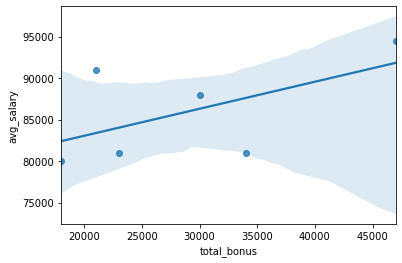

In [48]:
sns.regplot(x='total_bonus', y='avg_salary', data=dfpandas)

<div class="alert alert-danger">
    <b> Remember your local driver usually has very little memory compared to your cluster! Only bring limited rows or very aggregated data!<b>
</div>

The reverse is also possible. You can convert a pandas dataframe into a pyspark dataframe and keep doing operations on the cluster side.

In [49]:
df_to_cluster = dfpandas[['avg_salary', 'max_bonus']]
df_to_cluster.head()

avg_salary  max_bonus
0     81000.0      19000
1     91000.0      21000
2     81000.0      23000
3     80000.0      18000
4     94500.0      24000

In [50]:
df_on_cluster = spark.createDataFrame(df_to_cluster)

In [51]:
df_on_cluster.show()

+----------+---------+
|avg_salary|max_bonus|
+----------+---------+
|   81000.0|    19000|
|   91000.0|    21000|
|   81000.0|    23000|
|   80000.0|    18000|
|   94500.0|    24000|
|   88000.0|    20000|
+----------+---------+



<div class="alert alert-warning">
    <b> This is just scratching the surface of what pyspark can do. You can find more content on moodle.<b>
</div>

Let's go over a use-case of what pyspark can actually do.

In [52]:
spark.stop()